In [1]:
import torch

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.current_device()

0

In [4]:
torch.cuda.device_count()

1

In [5]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1660 SUPER'

In [6]:
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

from sklearn import metrics
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import time

In [7]:
ROOT = '.data'

train_data = torchvision.datasets.MNIST(root=ROOT, train=True, download=True)

In [10]:
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

In [11]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(5, fill=(0,)),
    transforms.RandomCrop(28, padding=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

In [12]:
train_data = torchvision.datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = torchvision.datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

In [13]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 60000
Number of testing examples: 10000


In [14]:
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

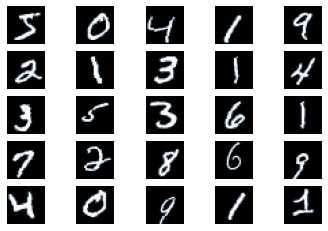

In [15]:
N_IMAGES = 25

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]

plot_images(images)

In [16]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

In [17]:
train_dta, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

In [18]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 60000
Number of validation examples: 6000
Number of testing examples: 10000


In [19]:
BATCH_SIZE = 128

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

In [32]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)
    
    def forward(self, x):
        
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        h_1 = F.relu(self.input_fc(x))
        h_2 = F.relu(self.hidden_fc(h_1))
        y_pred = self.output_fc(h_2)
        
        return y_pred, h_2

In [33]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = MLP(INPUT_DIM, OUTPUT_DIM)

In [34]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [35]:
print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 222,360 trainable parameters


In [36]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()


In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

In [38]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [43]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    
    for (x, y) in tqdm(iterator, desc="Training", leave=False):
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        y_pred, _ = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [44]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [45]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [46]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 20s
	Train Loss: 0.451 | Train Acc: 86.01%
	 Val. Loss: 0.217 |  Val. Acc: 93.25%


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 19s
	Train Loss: 0.178 | Train Acc: 94.65%
	 Val. Loss: 0.156 |  Val. Acc: 95.36%


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 19s
	Train Loss: 0.139 | Train Acc: 95.74%
	 Val. Loss: 0.123 |  Val. Acc: 96.20%


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 19s
	Train Loss: 0.119 | Train Acc: 96.34%
	 Val. Loss: 0.112 |  Val. Acc: 96.72%


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 19s
	Train Loss: 0.107 | Train Acc: 96.71%
	 Val. Loss: 0.102 |  Val. Acc: 96.93%


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 20s
	Train Loss: 0.096 | Train Acc: 97.04%
	 Val. Loss: 0.089 |  Val. Acc: 97.15%


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 19s
	Train Loss: 0.089 | Train Acc: 97.16%
	 Val. Loss: 0.085 |  Val. Acc: 97.23%


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 19s
	Train Loss: 0.083 | Train Acc: 97.43%
	 Val. Loss: 0.082 |  Val. Acc: 97.44%


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 19s
	Train Loss: 0.080 | Train Acc: 97.47%
	 Val. Loss: 0.069 |  Val. Acc: 97.73%


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 19s
	Train Loss: 0.077 | Train Acc: 97.62%
	 Val. Loss: 0.071 |  Val. Acc: 97.81%


In [47]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [48]:
images, labels, probs = get_predictions(model, test_iterator, device)

pred_labels = torch.argmax(probs, 1)

In [49]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

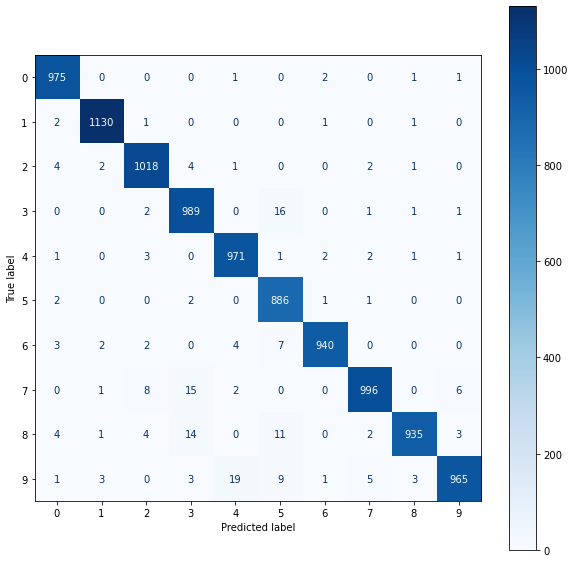

In [50]:
plot_confusion_matrix(labels, pred_labels)
